<a href="https://colab.research.google.com/github/Jorgecardetegit/NLP/blob/main/Extractive_question_answering_with_HuggingFace%F0%9F%A4%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive question answering

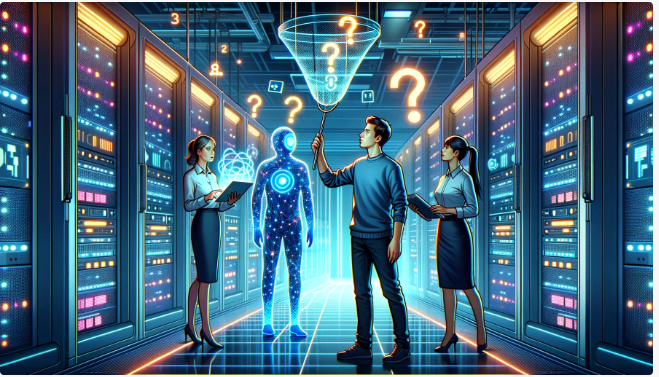

# Import libraries and install dependencies

In [1]:
import importlib.util

# Function to check if a library is installed
def is_library_installed(name):
    spec = importlib.util.find_spec(name)
    return spec is not None

# Check if both 'transformers' and 'datasets' are installed
if not is_library_installed('transformers') or not is_library_installed('datasets') or not is_library_installed('sacrebleu'): #or not is_library_installed('evaluate'):
    !pip install transformers datasets evaluate

    # !pip install sacreblue

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.8 MB/s eta 0:00:00


## Libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

from numpy import random

In [16]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from transformers import DataCollatorWithPadding, create_optimizer, AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM, LongformerTokenizerFast,TFLongformerForQuestionAnswering

from datasets import load_dataset

import evaluate

In [4]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [5]:
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

In [6]:
import datetime
import pathlib
import io
import os
import re
import string
import time
import gensim.downloader as api

In [7]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load dataset

In [ ]:
dataset_id = "covid_qa_deepset"
dataset=load_dataset(dataset_id)


# 3. Basic EDA

In [9]:
print(dataset)

print(f"\nStructure of the dataset: {type(dataset['train'])}")

DatasetDict({
    train: Dataset({
        features: ['document_id', 'context', 'question', 'is_impossible', 'id', 'answers'],
        num_rows: 2019
    })
})

Structure of the dataset: <class 'datasets.arrow_dataset.Dataset'>


In [13]:
print(dataset["train"][0]["context"])

Functional Genetic Variants in DC-SIGNR Are Associated with Mother-to-Child Transmission of HIV-1

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2752805/

Boily-Larouche, Geneviève; Iscache, Anne-Laure; Zijenah, Lynn S.; Humphrey, Jean H.; Mouland, Andrew J.; Ward, Brian J.; Roger, Michel
2009-10-07
DOI:10.1371/journal.pone.0007211
License:cc-by

Abstract: BACKGROUND: Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. Given that the C-type lectin receptor, dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lymph node–specific ICAM-grabbing non-integrin (L-SIGN)), can interact with pathogens including HIV-1 and is expressed at the maternal-fetal interface, we hypothesized that it could influence MTCT of HIV-1. METHODS AND FINDINGS: To investigate the potential role of DC-SIGNR in MTCT of HIV-1, we carried out a genetic association study of DC-SIGNR in a well-characterized cohort of 197 HIV-infec

# 4. Prepocessing

In [17]:
model_id="allenai/longformer-large-4096-finetuned-triviaqa"
tokenizer = LongformerTokenizerFast.from_pretrained(model_id)

In [19]:
MAX_LENGTH=512

tokenized_examples = tokenizer(
    dataset['train'][0]['question'],
    dataset['train'][0]["context"],
    truncation="only_second",
    max_length=MAX_LENGTH,
    stride=64,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
)

In [20]:
sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
offset_mapping = tokenized_examples.pop("offset_mapping")

tokenized_examples["start_positions"] = []
tokenized_examples["end_positions"] = []

In [21]:
for i, offsets in enumerate(offset_mapping):
  if len(dataset['train'][0]['answers']['answer_start'])==0:
    tokenized_examples["start_positions"].append(0)
    tokenized_examples["end_positions"].append(0)
  else:

    start_char=dataset['train'][0]['answers']['answer_start'][0]
    end_char=start_char+len(dataset['train'][0]['answers']['text'][0])
    found=0
    start_token_position=0
    end_token_position=0

    for j,offset in enumerate(offsets):
      if offset[0]<=start_char and offset[1]>=start_char and found==0:
        start_token_position=j
        end_token_position=MAX_LENGTH

        found=1
      if offset[1]>=end_char and found==1:
        end_token_position=j
        break
    tokenized_examples["start_positions"].append(start_token_position)
    tokenized_examples["end_positions"].append(end_token_position)

In [26]:
  def preprocess_function(dataset):

    questions = [q.lstrip() for q in dataset["question"]]
    paragraphs = [p.lstrip() for p in dataset["context"]]

    tokenized_examples = tokenizer(
      questions,
      paragraphs,
      truncation="only_second",
      max_length=MAX_LENGTH,
      stride=64,
      return_overflowing_tokens=True,
      return_offsets_mapping=True,
      padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []#[152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tokenized_examples["end_positions"] = []#[172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    for i, offsets in enumerate(offset_mapping):
      sample_index = sample_mapping[i]

      start_char=dataset["answers"][sample_index]['answer_start'][0]
      end_char=start_char+len(dataset["answers"][sample_index]['text'][0])
      found=0
      start_token_position=0
      end_token_position=0

      for j,offset in enumerate(offsets):
        if offset[0]<=start_char and offset[1]>=start_char and found==0:
          start_token_position=j
          end_token_position=MAX_LENGTH
          found=1
        if offset[1]>=end_char and found==1:
          end_token_position=j
          break
      tokenized_examples["start_positions"].append(start_token_position)
      tokenized_examples["end_positions"].append(end_token_position)

    return tokenized_examples


In [27]:
tokenized_dataset=dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/2019 [00:00<?, ? examples/s]